## Imports, Paths, View Examples

In [1]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Define paths
#base_dir = '/content/drive/MyDrive/logo_detection/logo_detection_w281/' # Colab/GDrive
base_dir = '/Users/jetcalz07/Desktop/MIDS/W281_CV/logo_detection_w281/'
image_dir = base_dir + 'data/images/'
os.chdir(base_dir)

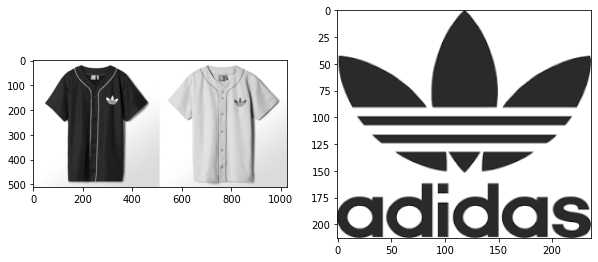

In [2]:
# Load example image and reference
adidas_dir = image_dir + 'adidas/'
img_file = os.listdir(adidas_dir)[0]
img_rgb = cv2.imread(adidas_dir + img_file)
img_gray = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2GRAY)

# Load adidas template
ref_dir = base_dir + 'data/logo_references/adidas/'
ref_rgb = cv2.imread(ref_dir + os.listdir(ref_dir)[0])
ref_gray = cv2.cvtColor(ref_rgb, cv2.COLOR_RGB2GRAY)

fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(img_gray, cmap='gray')
ax[1].imshow(ref_gray, cmap='gray')
plt.show()

## Helper Functions
1. resize_reference(ref, scale_percent)
    - Resize the reference image in case it is smaller or large in the input image (unlikely to be perfect match to start)
2. find_matches:
    - Find 1 or multiple matches of logo reference in the input image
    - The number of bounding boxes is determined by the number of points that beat a threshold criteria
        - If none meet criteria, we pick the box with the greatest likelihood value
    - Given reference image, take the inverted version and perform template matching here as well
        - If neither normal or inverted reference find a box that beats threshold, pick the best of the 2 instead of picking one of each
    - TO-DO:
        - If multiple boxes overlap, pick the best of the set
        - Determine optimal threshold
            - One approach: Get the # of boxes returned at each threshold increment, find the threshold that has steepest drop off (ex: dropoff from 50 boxes to 3)
            - Another idea: Given the max likelihood bounding box, only return other bounding boxes within a certain range of the max (ex: can't return bbox with 40% likelihood if another has 75%, even if 40% is the next most likely)


In [20]:
# Try other shapes for reference
def resize_reference(ref, scale_percent):
    ref_copy = ref.copy()
    width = int(ref_copy.shape[1] * scale_percent)
    height = int(ref_copy.shape[0] * scale_percent)
    ref_re = cv2.resize(ref_copy, (width, height))
    return ref_re

In [310]:
def reduce_overlap(bbox_pts, bbox_stats, w, h, buffer = 0.9):
    final_pts = []
    final_stats = []
    olap_sets = []
    bbox_un = np.unique(bbox_pts, axis=0)
    x_vals = bbox_un[:, 0]
    y_vals = bbox_un[:, 1]

    # find overlap sets
    for i in range(len(bbox_un)):
        pt = bbox_un[i]
        x_olap = np.abs(x_vals - pt[0]) < (w*buffer)
        y_olap = np.abs(y_vals - pt[1]) < (h*buffer)
        olap = np.array(list(zip(x_olap, y_olap)))
        olap_inds = list(np.where((olap[:, 0] == True) & (olap[:, 1] == True))[0])
        olap_sets.append(olap_inds)

    # trim to only unique overlap sets
    olap_sets_un = [list(x) for x in set(tuple(x) for x in olap_sets)]
    print(olap_sets_un)

    # for each overlap set, get the index with highest bbox_stat
    for olap_set in olap_sets_un:
        grab_ind = np.argmax(bbox_stats[olap_set])
        keep_ind = olap_set[grab_ind]
        final_pts.append(bbox_un[keep_ind])
        final_stats.append(np.max(bbox_stats[olap_set]))

    return final_pts, final_stats, olap_sets_un

# NEED TO RETHINK THE OVERLAP THING, TOO COMPLICATED?

In [311]:
def find_matches(img_rgb, img_gray, ref, method='cv2.TM_CCOEFF_NORMED', threshold = 0.4, overlap_buffer=0.9):
    img_copy = img_gray.copy()
    img_rgb_copy = img_rgb.copy()
    ref_copy = ref.copy()
    w, h = ref_copy.shape[::-1]
    method = eval(method)
    bbox_pts = [] # array of all points above threshold
    bbox_stats = np.array([]) # array of likelihood values for each box returned

    # Perform template matching - normal reference
    res = cv2.matchTemplate(img_copy, ref_copy, method)
    loc = np.where(np.abs(res) >= threshold) # find all box locations that beat threshold
    pts = [x for x in zip(*loc[::-1])]

    # Perform template matching - inverted reference
    res_inv = cv2.matchTemplate(img_copy, 255-ref_copy, method)
    loc_inv = np.where(np.abs(res_inv) >= threshold)
    pts_inv = [x for x in zip(*loc_inv[::-1])]

    # get unique bbox pts
    for pt in pts:
        bbox_pts.append(pt)
        bbox_stats = np.append(bbox_stats, np.abs(res[pt[1], pt[0]]))
    for pt in pts_inv:
        bbox_pts.append(pt)
        bbox_stats = np.append(bbox_stats, np.abs(res_inv[pt[1], pt[0]]))
    final_bboxes, final_stats, olap_sets_un = reduce_overlap(bbox_pts, bbox_stats, w, h, buffer = overlap_buffer)

    for point in final_bboxes:
        cv2.rectangle(img_rgb_copy, point, (point[0] + w, point[1] + h), (0,0,255), 2)

    # If any points beat threshold (normal/inverse reference)
    #if (len(pts) > 0) | ():
    # If >=1 boxes beat threshold for normal reference, store the points in running list
    # if len(pts) > 0:
    #     for pt in pts:
    #         cv2.rectangle(img_rgb_copy, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    #         #bbox_stats = np.append(bbox_stats, res[pt[1], pt[0]])
    
    # # If >=1 boxes beat threshold for inverted reference, store the points in running list
    # if len(pts_inv) > 0:
    #     for pt in pts_inv:
    #         cv2.rectangle(img_rgb_copy, pt, (pt[0] + w, pt[1] + h), (0,0,255), 2)
    #         #bbox_stats = np.append(bbox_stats, res[pt[1], pt[0]])

    # If neither reference returns a box that beats threshold, get best box from both references and pick best of the two
    if (len(pts) == 0) & (len(pts_inv) == 0):
        # next best box for normal reference
        min_val, max_val, min_loc, max_loc = cv2.minMaxLoc(res)
        # next best box for inverted reference
        min_val_inv, max_val_inv, min_loc_inv, max_loc_inv = cv2.minMaxLoc(res_inv)
        # go with best of the two above
        if max_val > max_val_inv: # use best box from normal reference
            top_left = max_loc
            bbox_stats = np.append(bbox_stats, [max_val])
            bottom_right = (top_left[0] + w, top_left[1] + h)
            rect = cv2.rectangle(img_rgb_copy, top_left, bottom_right, (0,0,255), 2)
        else: # inverted reference returned the most likely bounding box
            top_left = max_loc_inv
            bbox_stats = np.append(bbox_stats, [max_val_inv])
            bottom_right = (top_left[0] + w, top_left[1] + h)
            rect = cv2.rectangle(img_rgb_copy, top_left, bottom_right, (0,0,255), 2)

    return img_rgb_copy, final_stats, final_bboxes, olap_sets_un

[[4, 5], [0, 1, 2, 3]]
[[4, 5], [0, 1, 2, 3]]


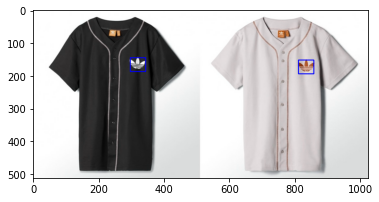

In [317]:
## Ideal case
# Without inverted reference above and we would not get the black jersey box
ref_resize = resize_reference(ref_gray, 0.2) # resize
result, bbox_stats, bbox_pts, olap_sets_un = find_matches(img_rgb, img_gray, ref_resize, threshold=0.4, overlap_buffer=0.8)
print(olap_sets_un)
#print(bbox_stats)
plt.imshow(result)

### Areas to Explore
1. Find optimal image size
2. Find optimal threshold (diff threshold for each logo?)
3. Other transformations to reference image (to do)
4. Different template match methods

In [90]:
# DF to track experiment results
df = pd.DataFrame({
    'input_img': np.array([]),
    'ref_size': np.array([], dtype='float32'), 
    'method': np.array([]),
    'threshold': np.array([], dtype='float32'),
    'num_bboxes': np.array([], dtype=int),
    'bbox_vales': np.array([], dtype='float32'),
    }
)

### Experiment 1: Resize Reference Image

[0.37899315 0.41152778 0.41439831 0.40951663 0.41764221 0.45577759
 0.48737016 0.49599111 0.4957597  0.49243018 0.47295359 0.43831596
 0.40086016 0.40383667 0.41087461 0.41987008 0.42424747 0.40856338
 0.41152778 0.41439831 0.40951663 0.41764221 0.45577759 0.48737016
 0.49599111 0.4957597  0.49243018 0.47295359 0.43831596 0.40086016
 0.3108027  0.28081122]


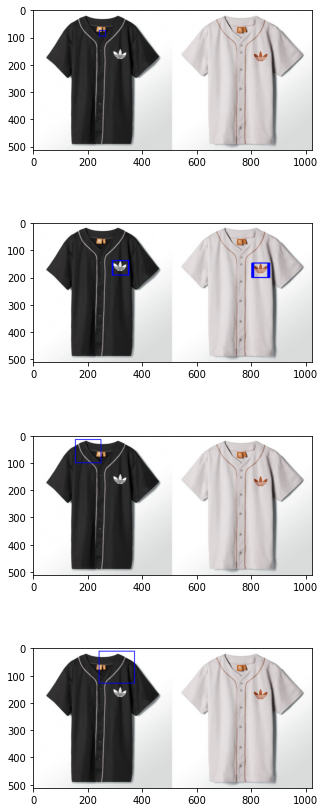

In [95]:
percs = np.arange(0.1, 0.6, 0.15)
vals = np.array([])

r_copy = ref_gray.copy()
rgb = img_rgb.copy()
gray = img_gray.copy()
threshold = 0.4

fig, ax = plt.subplots(len(percs), 1, figsize=(5, 15))
for i in range(len(percs)):
    ref_resize = resize_reference(r_copy, percs[i]) # resize
    rect_res, bbox_stats = find_matches(rgb, gray, ref_resize, threshold=threshold) # eval
    vals = np.append(vals, bbox_stats)
    df.loc[len(df.index)] = [img_file, ref_resize.shape, 'cv2.TM_CCOEFF_NORMED', threshold, len(bbox_stats), bbox_stats]
    ax[i].imshow(rect_res)

print(vals)

In [92]:
# check results
df.head()
### Add Reference Image Augmentations (rotation, affine transfor, etc.)

,input_img,ref_size,method,threshold,num_bboxes,bbox_vales
0,000152.jpg,"(21, 23)",cv2.TM_CCOEFF_NORMED,0.4,1,[0.3789931535720825]
1,000152.jpg,"(53, 59)",cv2.TM_CCOEFF_NORMED,0.4,29,"[0.4115277826786041, 0.41439831256866455, 0.40..."
2,000152.jpg,"(85, 94)",cv2.TM_CCOEFF_NORMED,0.4,1,[0.310802698135376]
3,000152.jpg,"(117, 130)",cv2.TM_CCOEFF_NORMED,0.4,1,[0.28081122040748596]


### Experiment 2: Try rotation of reference image

### Experiment X: Template Match Methods

KeyboardInterrupt: 

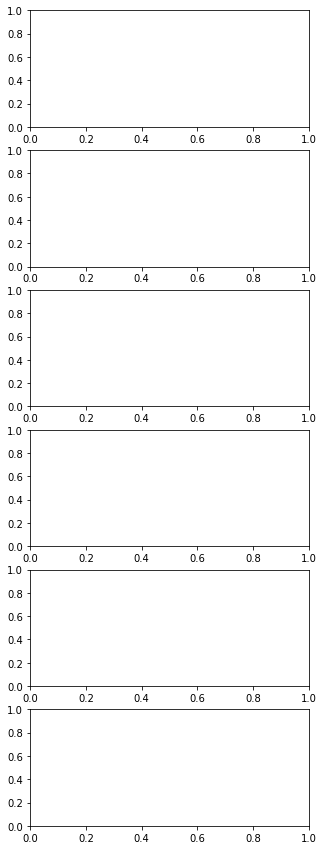

In [94]:
# methods = ['cv2.TM_CCOEFF', 'cv2.TM_CCOEFF_NORMED', 'cv2.TM_CCORR',
# 'cv2.TM_CCORR_NORMED', 'cv2.TM_SQDIFF', 'cv2.TM_SQDIFF_NORMED']
# vals = np.array([])

# fig, ax = plt.subplots(len(methods), 1, figsize=(5, 15))
# for i in range(len(methods)):
#     ref_resize = resize_reference(r_copy, 0.2) # resize
#     rect_res, val = find_matches(rgb, gray, ref_resize, methods[i]) # eval
#     vals = np.append(vals, val)
#     df.loc[len(df.index)] = [val, ref_resize.shape, methods[i]]
#     ax[i].imshow(rect_res)

# print(list(zip(methods, vals)))